<a href="https://colab.research.google.com/github/novita824/PCVK_Genap_2023/blob/main/FinalProject(FaceGenderDetection).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive

# Accesing My Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")

In [11]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense, Flatten, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.optimizers import SGD

In [12]:
from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64
plt.style.use("ggplot")
%matplotlib inline

In [13]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [14]:
main_folder = "/content/drive/MyDrive/PCVK(Face Detection)/img_align_celeba/img_align_celeba/"
images_folder = main_folder + "img_align_celeba/"

example_pic = images_folder + "000110.jpg"

training_sample = 10000
validation_sample = 2000
test_sample = 2000
img_width = 178
img_height = 218
batch_size = 16
num_epochs = 5

In [15]:
df_attr = pd.read_csv(main_folder + '/csv/list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True)

In [16]:
df_attr.head(5)

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [17]:
df_attr.describe()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
count,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,...,202599.000000,202599.00000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000
mean,0.111136,0.266981,0.512505,0.204572,0.022443,0.151575,0.240796,0.234532,0.239251,0.147992,...,0.056511,0.48208,0.208402,0.319567,0.188925,0.048460,0.472436,0.122967,0.072715,0.773617
std,0.314301,0.442383,0.499845,0.403389,0.148121,0.358610,0.427568,0.423707,0.426627,0.355093,...,0.230906,0.49968,0.406167,0.466310,0.391450,0.214737,0.499241,0.328400,0.259669,0.418491
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.00000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
df_attr.columns

Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')

In [19]:
df_attr.isnull().sum()

5_o_Clock_Shadow       0
Arched_Eyebrows        0
Attractive             0
Bags_Under_Eyes        0
Bald                   0
Bangs                  0
Big_Lips               0
Big_Nose               0
Black_Hair             0
Blond_Hair             0
Blurry                 0
Brown_Hair             0
Bushy_Eyebrows         0
Chubby                 0
Double_Chin            0
Eyeglasses             0
Goatee                 0
Gray_Hair              0
Heavy_Makeup           0
High_Cheekbones        0
Male                   0
Mouth_Slightly_Open    0
Mustache               0
Narrow_Eyes            0
No_Beard               0
Oval_Face              0
Pale_Skin              0
Pointy_Nose            0
Receding_Hairline      0
Rosy_Cheeks            0
Sideburns              0
Smiling                0
Straight_Hair          0
Wavy_Hair              0
Wearing_Earrings       0
Wearing_Hat            0
Wearing_Lipstick       0
Wearing_Necklace       0
Wearing_Necktie        0
Young                  0


In [20]:
df_attr.shape

(202599, 40)

In [21]:
for i,j in enumerate(df_attr.columns):
    print(i+1, j)

1 5_o_Clock_Shadow
2 Arched_Eyebrows
3 Attractive
4 Bags_Under_Eyes
5 Bald
6 Bangs
7 Big_Lips
8 Big_Nose
9 Black_Hair
10 Blond_Hair
11 Blurry
12 Brown_Hair
13 Bushy_Eyebrows
14 Chubby
15 Double_Chin
16 Eyeglasses
17 Goatee
18 Gray_Hair
19 Heavy_Makeup
20 High_Cheekbones
21 Male
22 Mouth_Slightly_Open
23 Mustache
24 Narrow_Eyes
25 No_Beard
26 Oval_Face
27 Pale_Skin
28 Pointy_Nose
29 Receding_Hairline
30 Rosy_Cheeks
31 Sideburns
32 Smiling
33 Straight_Hair
34 Wavy_Hair
35 Wearing_Earrings
36 Wearing_Hat
37 Wearing_Lipstick
38 Wearing_Necklace
39 Wearing_Necktie
40 Young


## Load Image

In [22]:
img_path = '/content/drive/MyDrive/PCVK(Face Detection)/img_align_celeba/img_align_celeba/000110.jpg'

In [23]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

Brown_Hair    1
Male          0
Bangs         1
Name: 000110.jpg, dtype: int64

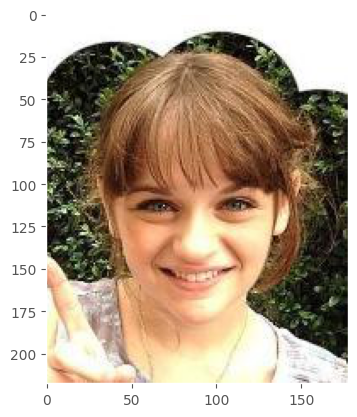

In [24]:
img = load_img(img_path)
plt.grid(False)
plt.imshow(img)
df_attr.loc[img_path.split('/')[-1]][['Brown_Hair','Male',"Bangs"]]

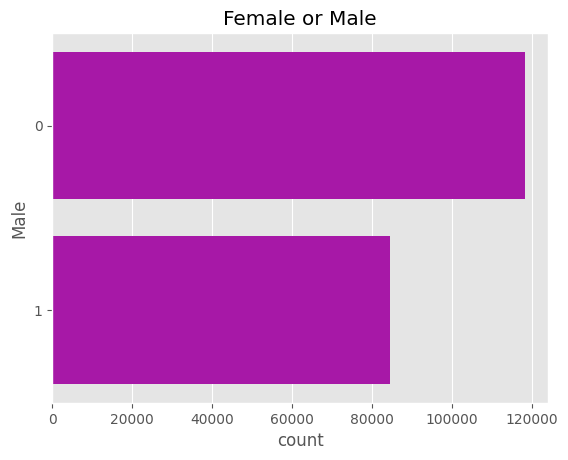

In [25]:
# Female or Male ?
plt.title('Female or Male')
sns.countplot(y='Male', data=df_attr, color='m')
plt.show()

## Split Dataset into Training, Validation and Test

In [26]:
# Recomended partition
df_partition = pd.read_csv(main_folder + '/csv/list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [27]:
df_partition.sample(100)

,image_id,partition
178836,178837.jpg,1
178347,178348.jpg,1
195501,195502.jpg,2
102307,102308.jpg,0
136879,136880.jpg,0
...,...,...
5066,005067.jpg,0
107542,107543.jpg,0
172652,172653.jpg,1
167439,167440.jpg,1


In [28]:
# display counter by partition
# 0 -> TRAINING
# 1 -> VALIDATION
# 2 -> TEST
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

In [29]:
# join the partition with the attributes
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Male'], how='inner')
df_par_attr.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


In [30]:
df_par_attr.shape

(202599, 2)

Generate Partitions (Train, Validation, Test)

In [31]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x


def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test

    '''

    df_ = df_par_attr[(df_par_attr['partition'] == partition)
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition)
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr],2)

    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

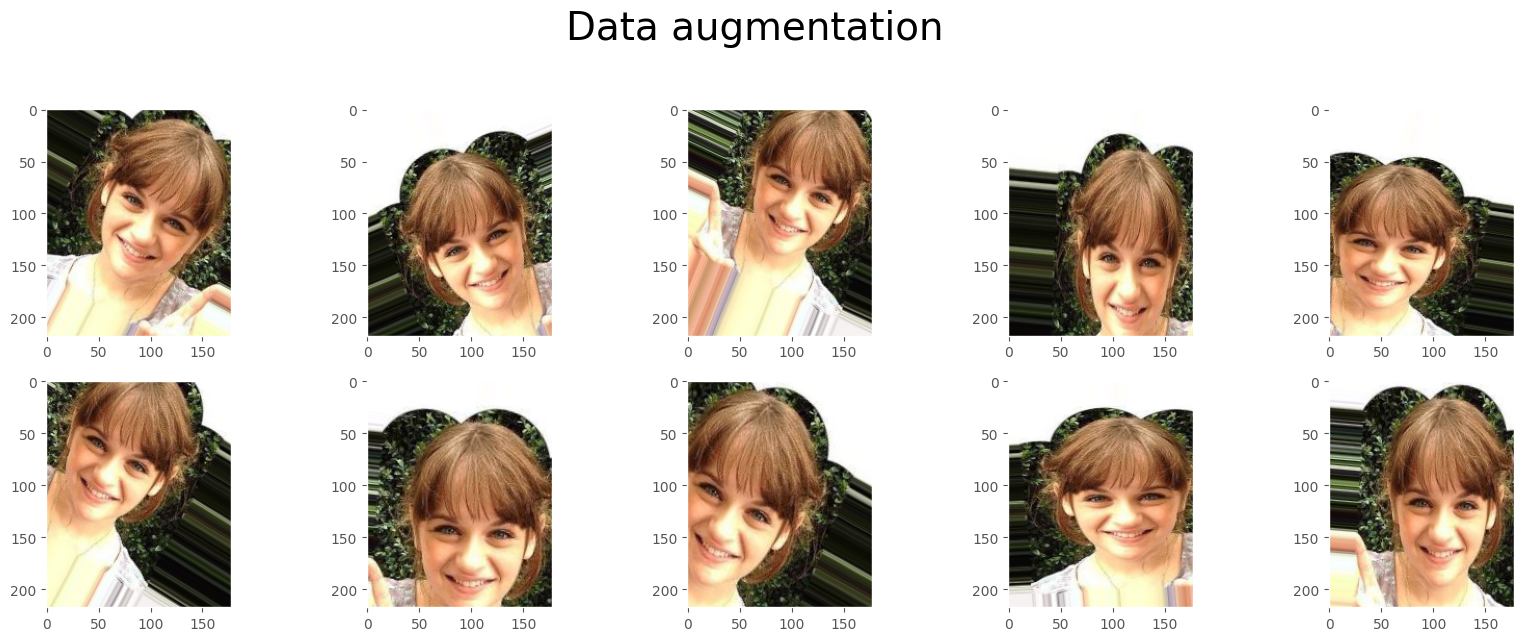

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# generate image generator for data augmentation
datagen = ImageDataGenerator(rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

# load one image and reshape
img = load_img(img_path)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded image

plt.figure(figsize=(20,10))
plt.suptitle("Data augmentation", fontsize=28)

i = 0

for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3,5,i+1)
    plt.grid(False)
    plt.imshow(batch.reshape(218,178, 3))

    if i==9:
        break
    i = i+1

plt.show()

In [33]:
# build data generators

# train data

x_train, y_train = generate_df(0, "Male", training_sample)

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)

FileNotFoundError: ignored

## Build the Model - Gender Recognition

In [34]:
# Import InceptionV3 Model
inc_model = InceptionV3(weights="/content/drive/MyDrive/PCVK(Face Detection)/img_align_celeba/img_align_celeba/",
                        include_top=False,)

print("number of layers:", len(inc_model.layers))
#inc_model.summary()

IsADirectoryError: ignored